<a href="https://colab.research.google.com/github/Francisco-Italo/ml2023-Italo-Moraes/blob/master/Freezing-of-gait-dt/FOG_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# O presente modelo visa identificar a probabilidade de ocorrência de um indivíduo ter manifestado um evento de congelamento da marcha - ou do andar - (FOG, do inglês "freezing of gait"), que são: hesitação ao iniciar uma caminhada, dificuldade em fazer uma curva, e parada brusca enquanto caminha.
# O dataset contém os a seguintes colunas:

*   Time: Timestamp do registro.
*   AccV: valor do acelerômetro no eixo vertical.
*   AccML: valor do acelerômetro no eixo meio-lateral.
*   AccAP: valor do acelerômetro no eixo anteroposterior.
*   StartHesitation: Dificuldade em começar uma caminhada.
*   Turn: Dificuldade em fazer uma curva.
*   Walking: Parada brusca na caminhada.
*   Valid: Marcado como False se não há certeza da detecção do evento.
*   Task: Anotações registradas pelos pesquisadores. 



In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import os

## Armazenamento de dados em dois datasets: treino e teste. Como o dataset de treino contém 3 outros subdiretórios, optou-se por retirar um subdiretório, que contém uma coluna diferente dos outros dois subdiretórios, além de conter menos atributos.

In [2]:
def join_dfs(dir_path):
  subfolders = [f.path for f in os.scandir(dir_path) if f.is_dir()]

  dataframes = []
  # Subdiretório que será retirado 
  black_sheep = 'notype'
  # Neste subdiretório, os dados dos subdiretórios estão em g, por isso,
  # será efetuada a conversão de escala, de g para m/s^2
  need_convertion = 'defog'

  for sf in subfolders:
    if black_sheep in sf: continue

    pat = os.path.join(sf, '*.csv')      
    f_list = glob.glob(pat)

    i = 0
    for file in f_list:
      if i == 15: break
      
      df = pd.read_csv(file)
      # Conversão de g para m/s^2
      if need_convertion in sf: df = df.applymap(lambda x: x * 9.8 if pd.api.types.is_float_dtype(x) else x)
      dataframes.append(df)
      i = i+1
  
  return dataframes

In [3]:
dir_path = '/content/drive/MyDrive/FOG-dataset/train/'
df_train = pd.concat(join_dfs(dir_path), axis=0, ignore_index=True)

dir_path = '/content/drive/MyDrive/FOG-dataset/test/'
df_test = pd.concat(join_dfs(dir_path), axis=0, ignore_index=True)

## Análise dos dados



In [4]:
df_train.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-8.934903,-0.045351,-3.295116,0,0,0,NaN,NaN
1,1,-8.921293,-0.050063,-3.304153,0,0,0,NaN,NaN
2,2,-8.922881,-0.040125,-3.311976,0,0,0,NaN,NaN
3,3,-8.933698,-0.030371,-3.313792,0,0,0,NaN,NaN
4,4,-8.938324,-0.023556,-3.304763,0,0,0,NaN,NaN


In [5]:
df_test.head()

,Time,AccV,AccML,AccAP
0,0,-9.533939,0.566322,-1.413525
1,1,-9.536140,0.564137,-1.440621
2,2,-9.529345,0.561765,-1.429332
3,3,-9.531239,0.564227,-1.415490
4,4,-9.540825,0.561854,-1.429471


## Bateria de verificações:


1.   Formato do dataset
2.   Informações dos dados do dataset
3.   Colunas do dataset
4.   Tipos dos dados por coluna
5.   Contagem de dados faltantes
6.   Contagem de valores assinalados como verdadeiro e falso (apenas colunas Valid e Task)

## Ambas verificações valem para treino e teste


In [6]:
print(f"DataFrame shape : {df_train.shape}\n=================================")
print(f"DataFrame info : {df_train.info()}\n=================================")
print(f"DataFrame columns : {df_train.columns}\n=================================")
print(f"The type of each column : {df_train.dtypes}\n=================================")
print(f"How much missing value in every column : {df_train.isna().sum()}\n=================================")
print(f"True counts : {(df_train[['Valid','Task']] == True).sum()}\n=================================")
print(f"False counts : {(df_train[['Valid','Task']] == False).sum()}\n=================================")

DataFrame shape : (2345378, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345378 entries, 0 to 2345377
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Time             int64  
 1   AccV             float64
 2   AccML            float64
 3   AccAP            float64
 4   StartHesitation  int64  
 5   Turn             int64  
 6   Walking          int64  
 7   Valid            object 
 8   Task             object 
dtypes: float64(3), int64(4), object(2)
memory usage: 161.0+ MB
DataFrame info : None
DataFrame columns : Index(['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking',
       'Valid', 'Task'],
      dtype='object')
The type of each column : Time                 int64
AccV               float64
AccML              float64
AccAP              float64
StartHesitation      int64
Turn                 int64
Walking              int64
Valid               object
Task                object
dtype: object
How much mis

### Mudança das colunas do tipo 'object' para 'bool'

In [7]:
df_train.replace({'false':False,'true':True})
df_train.fillna(True)

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-8.934903,-0.045351,-3.295116,0,0,0,True,True
1,1,-8.921293,-0.050063,-3.304153,0,0,0,True,True
2,2,-8.922881,-0.040125,-3.311976,0,0,0,True,True
3,3,-8.933698,-0.030371,-3.313792,0,0,0,True,True
4,4,-8.938324,-0.023556,-3.304763,0,0,0,True,True
...,...,...,...,...,...,...,...,...,...
2345373,192651,-0.943479,-0.169817,-0.288977,0,0,0,False,False
2345374,192652,-0.943467,-0.155179,-0.282620,0,0,0,False,False
2345375,192653,-0.938662,-0.141621,-0.275849,0,0,0,False,False
2345376,192654,-0.931365,-0.136427,-0.272348,0,0,0,False,False


In [8]:
df_train['Valid'] = df_train['Valid'].astype(bool)
df_train['Task'] = df_train['Task'].astype(bool)

In [9]:
df_train

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-8.934903,-0.045351,-3.295116,0,0,0,True,True
1,1,-8.921293,-0.050063,-3.304153,0,0,0,True,True
2,2,-8.922881,-0.040125,-3.311976,0,0,0,True,True
3,3,-8.933698,-0.030371,-3.313792,0,0,0,True,True
4,4,-8.938324,-0.023556,-3.304763,0,0,0,True,True
...,...,...,...,...,...,...,...,...,...
2345373,192651,-0.943479,-0.169817,-0.288977,0,0,0,False,False
2345374,192652,-0.943467,-0.155179,-0.282620,0,0,0,False,False
2345375,192653,-0.938662,-0.141621,-0.275849,0,0,0,False,False
2345376,192654,-0.931365,-0.136427,-0.272348,0,0,0,False,False


### Reverificação

In [10]:
print(f"DataFrame shape : {df_train.shape}\n=================================")
print(f"DataFrame info : {df_train.info()}\n=================================")
print(f"DataFrame columns : {df_train.columns}\n=================================")
print(f"The type of each column : {df_train.dtypes}\n=================================")
print(f"How much missing value in every column : {df_train.isna().sum()}\n=================================")
print(f"True counts : {(df_train[['Valid','Task']] == True).sum()}\n=================================")
print(f"False counts : {(df_train[['Valid','Task']] == False).sum()}\n=================================")

DataFrame shape : (2345378, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345378 entries, 0 to 2345377
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Time             int64  
 1   AccV             float64
 2   AccML            float64
 3   AccAP            float64
 4   StartHesitation  int64  
 5   Turn             int64  
 6   Walking          int64  
 7   Valid            bool   
 8   Task             bool   
dtypes: bool(2), float64(3), int64(4)
memory usage: 129.7 MB
DataFrame info : None
DataFrame columns : Index(['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking',
       'Valid', 'Task'],
      dtype='object')
The type of each column : Time                 int64
AccV               float64
AccML              float64
AccAP              float64
StartHesitation      int64
Turn                 int64
Walking              int64
Valid                 bool
Task                  bool
dtype: object
How much missin

In [11]:
print(f"DataFrame shape : {df_test.shape}\n=================================")
print(f"DataFrame info : {df_test.info()}\n=================================")
print(f"DataFrame columns : {df_test.columns}\n=================================")
print(f"The type of each column : {df_test.dtypes}\n=================================")
print(f"How much missing value in every column : {df_test.isna().sum()}\n=================================")

DataFrame shape : (286370, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286370 entries, 0 to 286369
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    286370 non-null  int64  
 1   AccV    286370 non-null  float64
 2   AccML   286370 non-null  float64
 3   AccAP   286370 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 8.7 MB
DataFrame info : None
DataFrame columns : Index(['Time', 'AccV', 'AccML', 'AccAP'], dtype='object')
The type of each column : Time       int64
AccV     float64
AccML    float64
AccAP    float64
dtype: object
How much missing value in every column : Time     0
AccV     0
AccML    0
AccAP    0
dtype: int64


In [12]:
df_test

,Time,AccV,AccML,AccAP
0,0,-9.533939,0.566322,-1.413525
1,1,-9.536140,0.564137,-1.440621
2,2,-9.529345,0.561765,-1.429332
3,3,-9.531239,0.564227,-1.415490
4,4,-9.540825,0.561854,-1.429471
...,...,...,...,...
286365,281683,-0.899299,-0.232668,0.389147
286366,281684,-0.901973,-0.233051,0.390114
286367,281685,-0.901690,-0.231888,0.391896
286368,281686,-0.899576,-0.232429,0.391106


### Cálculos de:


1.   Média
2.   Desvio padrão
3.   Valores mínimo e máximo

### Os cálculos foram submetidos apenas aos valores dos acelerômetros

Vertical reading Mean:  -1.31395391899912
Vertical reading  Standard Deviation:  1.7213132533303745
Vertical reading  Minimum:  -25.1512224620068
Vertical reading  Maximum:  1.46351889198778

Mediolaeral reading Mean:  -0.002249219039978172
Mediolaeral reading  Standard Deviation:  0.25938233630639673
Mediolaeral reading  Minimum:  -19.8373213894814
Mediolaeral reading  Maximum:  24.5404936985729

Anteroposterior reading Mean:  -0.03024192966155013
Anteroposterior reading  Standard Deviation:  0.6947068550231541
Anteroposterior reading  Minimum:  -10.6161830010118
Anteroposterior reading  Maximum:  14.4212751481484


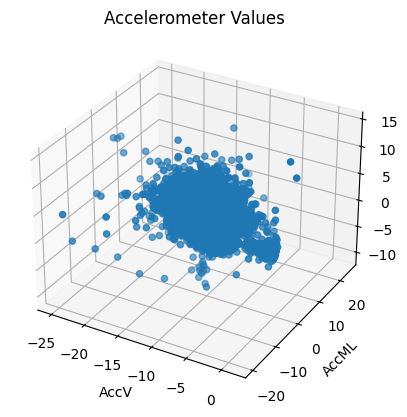

In [13]:
# Média
mean_value = df_train['AccV'].mean()

# Desvio padrão
std_deviation = df_train['AccV'].std()

# Mínimo valor encontrado
min_value = df_train['AccV'].min()

# Máximo valor encontrado
max_value = df_train['AccV'].max()

print("Vertical reading Mean: ", mean_value)
print("Vertical reading  Standard Deviation: ", std_deviation)
print("Vertical reading  Minimum: ", min_value)
print("Vertical reading  Maximum: ", max_value)
print()

mean_value = df_train['AccML'].mean()

std_deviation = df_train['AccML'].std()

min_value = df_train['AccML'].min()

max_value = df_train['AccML'].max()

print("Mediolaeral reading Mean: ", mean_value)
print("Mediolaeral reading  Standard Deviation: ", std_deviation)
print("Mediolaeral reading  Minimum: ", min_value)
print("Mediolaeral reading  Maximum: ", max_value)
print()

mean_value = df_train['AccAP'].mean()

std_deviation = df_train['AccAP'].std()

min_value = df_train['AccAP'].min()

max_value = df_train['AccAP'].max()

print("Anteroposterior reading Mean: ", mean_value)
print("Anteroposterior reading  Standard Deviation: ", std_deviation)
print("Anteroposterior reading  Minimum: ", min_value)
print("Anteroposterior reading  Maximum: ", max_value)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(df_train['AccV'], df_train['AccML'], df_train['AccAP'])

ax.set_xlabel('AccV')
ax.set_ylabel('AccML')
ax.set_zlabel('AccAP')
ax.set_title('Accelerometer Values')

plt.show()

### Matriz de correlação:

1.   Em relação aos valores dos acelerômetros
2.   Em relação às anotações de confiabilidade da detecção dos eventos
3.   Em relação aos valores dos acelerômetros e às colunas de confiabilidade de detecção dos eventos



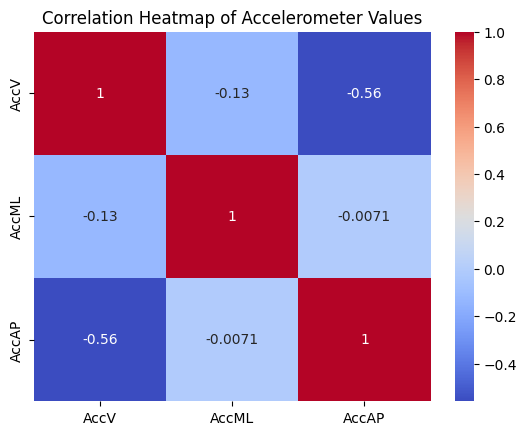

In [14]:
# Create a subset DataFrame with the accelerometer values
accelerometer_df = df_train[['AccV', 'AccML', 'AccAP']]
2
# Calculate the correlation matrix
correlation_matrix = accelerometer_df.corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Set the plot title
plt.title("Correlation Heatmap of Accelerometer Values")

# Show the plot
plt.show()

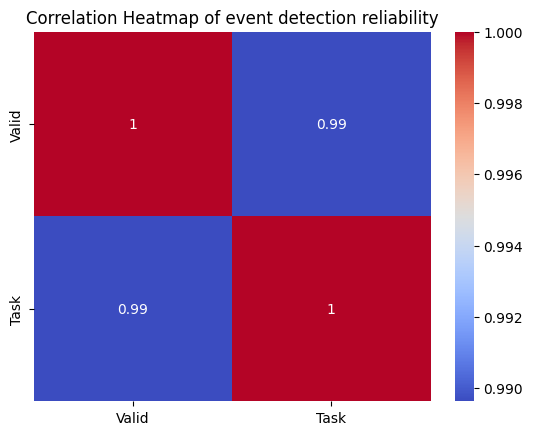

In [15]:
# Create a subset DataFrame with the accelerometer values
accelerometer_df = df_train[['Valid', 'Task']]

# Calculate the correlation matrix
correlation_matrix = accelerometer_df.corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Set the plot title
plt.title("Correlation Heatmap of event detection reliability")

# Show the plot
plt.show()

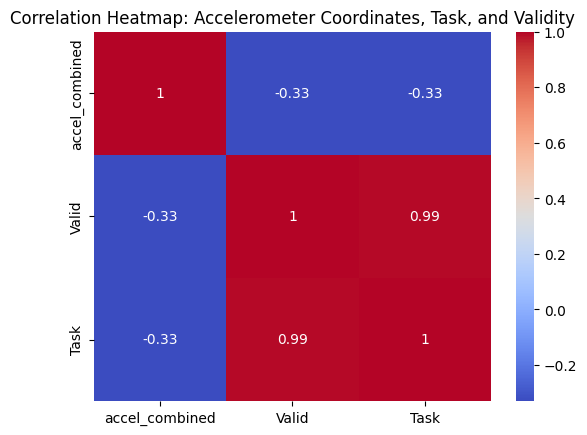

In [16]:
# Create a new column for combined accelerometer coordinates
df_train['accel_combined'] = df_train['AccV'] + df_train['AccML'] + df_train['AccAP']

# Create a subset DataFrame with the combined accelerometer coordinates, 'Task', and 'Valid' columns
subset_df = df_train[['accel_combined', 'Valid', 'Task']]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Set the plot title
plt.title("Correlation Heatmap: Accelerometer Coordinates, Task, and Validity")

# Show the plot
plt.show()

### Contagem de valores das colunas:

*   StartHesitation
*   Turn
*   Walking



In [17]:
# Calculate the occurrence counts for each event in column 1
hesitation_count = df_train['StartHesitation'].value_counts()

# Calculate the occurrence counts for each event in column 2
turn_count = df_train['Turn'].value_counts()

# Calculate the occurrence counts for each event in column 3
walk_count = df_train['Walking'].value_counts()

# Print the values
print(hesitation_count)
print(turn_count)
print(walk_count)

0    2345230
1        148
Name: StartHesitation, dtype: int64
0    2248168
1      97210
Name: Turn, dtype: int64
0    2343880
1       1498
Name: Walking, dtype: int64


## Tratamento dos dados

### Normalização

In [18]:
norm_for_train = df_train[['AccV','AccML','AccAP']]

scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(norm_for_train), columns=norm_for_train.columns)

df_train[df_norm.columns] = df_norm

Se o histograma tiver uma forma de curva gaussiana, significa que os dados foram normalizados

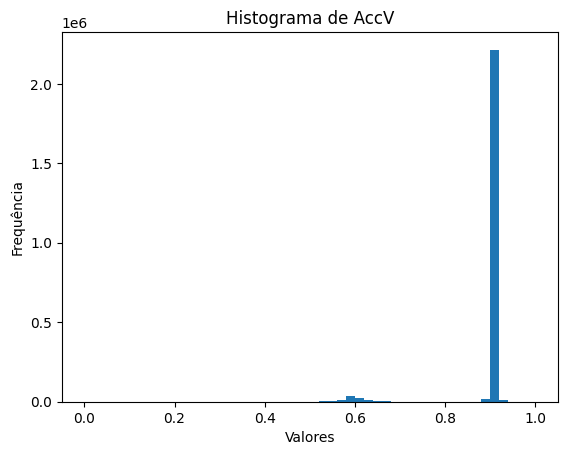

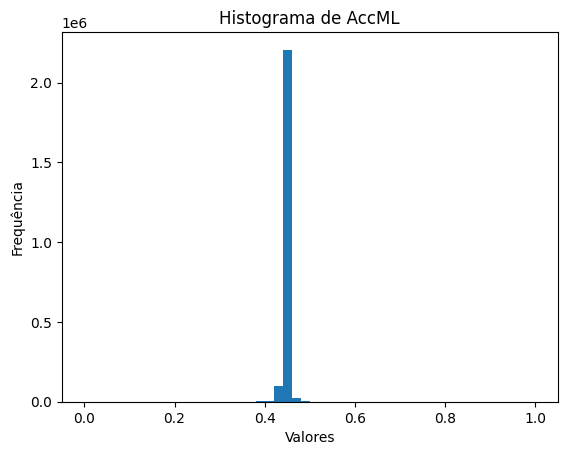

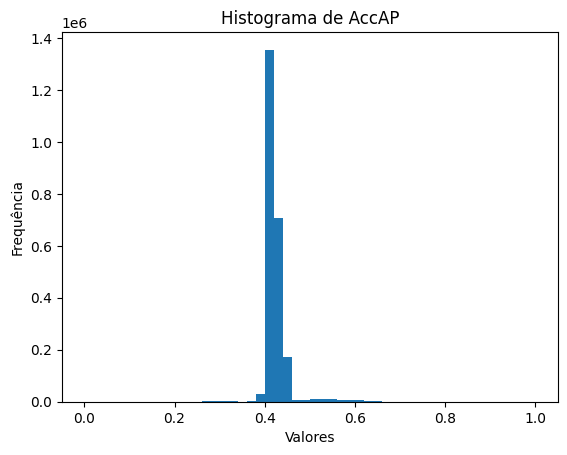

In [19]:
for column in norm_for_train.columns:
    plt.hist(df_train[column], bins=50)
    plt.title(f"Histograma de {column}")
    plt.xlabel("Valores")
    plt.ylabel("Frequência")
    plt.show()

Mudança do tipo das colunas 'Task' e 'Valid' de bool para inteiro, para permitir o treinamento com o dataset

In [20]:
to_integer = ['Task', 'Valid']

df_train[to_integer] = df_train[to_integer].astype(int)

## Treinamento

## Separação dos dados entre treino e teste.
## Os datasets foram separados em dois: valores dos acelerômetros e notificação de algum evento adicionalmente à confiabilidade comprovada da mesma.

In [21]:
# Separação das leituras de acelerômetros
accelerometer_cols = ['AccV', 'AccML', 'AccAP']
accelerometer_data = df_train[accelerometer_cols]

# Separação das colunas de eventos e anotação de confiabilidade
event_cols = ['StartHesitation', 'Turn', 'Walking']
reliability_cols = ['Valid', 'Task']
event_reliability_data = df_train[event_cols + reliability_cols]

# Separação entre teste e validação dos dados dos acelerômetros
accelerometer_train, accelerometer_val = train_test_split(accelerometer_data, test_size=0.2, random_state=42)

# Separação entre teste e validação das colunas de evento e confiabilidade das observações
event_reliability_train, event_reliability_val = train_test_split(event_reliability_data, test_size=0.2, random_state=42)

print('Accelerometer Train:', accelerometer_train.shape)
print('Accelerometer Validation:', accelerometer_val.shape)
print('Event and Reliability Train:', event_reliability_train.shape)
print('Event and Reliability Validation:', event_reliability_val.shape)

Accelerometer Train: (1876302, 3)
Accelerometer Validation: (469076, 3)
Event and Reliability Train: (1876302, 5)
Event and Reliability Validation: (469076, 5)


## Treinamento com a técnica de regressão linear
## As métricas de avaliação usadas foram as seguintes:


*   Erro Quadrático Médio (MSE - Mean Squared Error):
O MSE calcula a média dos quadrados das diferenças entre os valores previstos e os valores reais. Ele fornece uma medida geral da precisão das previsões do modelo. Um MSE menor indica um ajuste melhor entre as previsões do modelo e os valores reais.
*   Raiz do Erro Quadrático Médio (RMSE - Root Mean Squared Error):
O RMSE é a raiz quadrada do MSE. Ele fornece uma medida da magnitude média dos erros nas previsões. Assim como o MSE, um RMSE menor indica um ajuste melhor do modelo.
*   Erro Médio Absoluto (MAE - Mean Absolute Error):
O MAE calcula a média das diferenças absolutas entre os valores previstos e os valores reais. Da mesma forma que o MSE e o RMSE, um MAE menor indica um melhor desempenho do modelo.

In [22]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

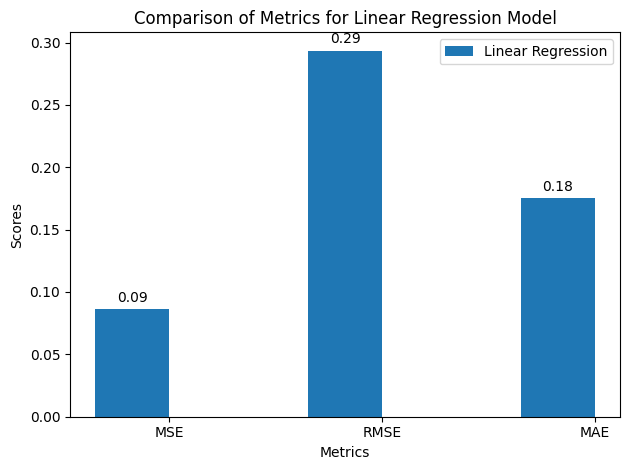

In [23]:
model = LinearRegression()

model.fit(accelerometer_train, event_reliability_train)

val_predictions = model.predict(accelerometer_val)

mse_model = mean_squared_error(event_reliability_val, val_predictions)
rmse_model = np.sqrt(mse_model)
mae_model = mean_absolute_error(event_reliability_val, val_predictions)

metrics = ['MSE', 'RMSE', 'MAE']
model_scores = [mse_model, rmse_model, mae_model]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
rects = ax.bar(x - width/2, model_scores, width, label='Linear Regression')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for Linear Regression Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

autolabel(rects)

plt.tight_layout()
plt.show()

## Treinamento usando a técnica árvore aleatória regressora

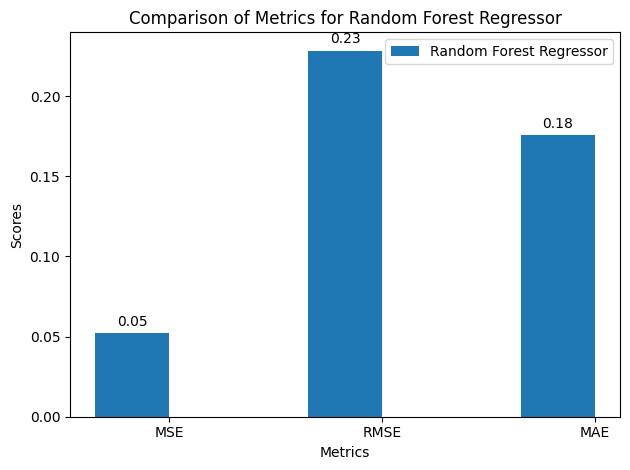

In [24]:
model = RandomForestRegressor(random_state=42)

model.fit(accelerometer_train, event_reliability_train)

predictions = model.predict(accelerometer_val)

mse_model = mean_squared_error(event_reliability_val, predictions)

rmse_model = np.sqrt(mse_model)
mae_model = mean_absolute_error(event_reliability_val, val_predictions)

metrics = ['MSE', 'RMSE', 'MAE']
model_scores = [mse_model, rmse_model, mae_model]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
rects = ax.bar(x - width/2, model_scores, width, label='Random Forest Regressor')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for Random Forest Regressor')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

autolabel(rects)

plt.tight_layout()
plt.show()

## Treinamento com conjunto de dados reduzido: retiradas as colunas Task e Valid

In [25]:
# Separação das leituras de acelerômetros
accelerometer_cols = ['AccV', 'AccML', 'AccAP']
accelerometer_data = df_train[accelerometer_cols]

# Separação das colunas de eventos e anotação de confiabilidade
event_cols = ['StartHesitation', 'Turn', 'Walking']
events_data = df_train[event_cols]

# Separação entre teste e validação dos dados dos acelerômetros
accelerometer_train, accelerometer_val = train_test_split(accelerometer_data, test_size=0.2, random_state=42)

# Separação entre teste e validação das colunas de evento e confiabilidade das observações
event_train, event_val = train_test_split(events_data, test_size=0.2, random_state=42)

print('Accelerometer Train:', accelerometer_train.shape)
print('Accelerometer Validation:', accelerometer_val.shape)
print('Event Train:', event_train.shape)
print('Event Validation:', event_val.shape)

Accelerometer Train: (1876302, 3)
Accelerometer Validation: (469076, 3)
Event Train: (1876302, 3)
Event Validation: (469076, 3)


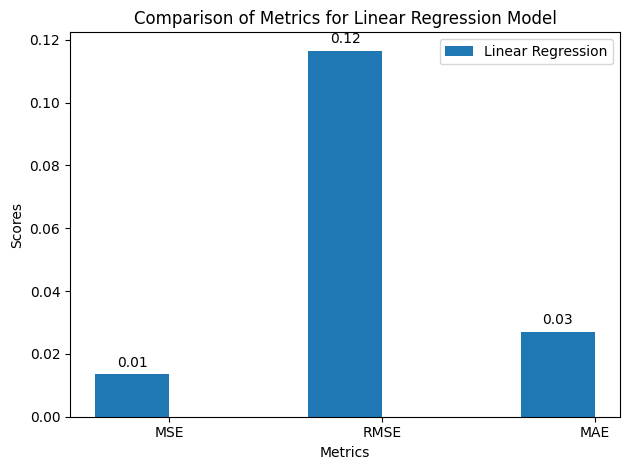

In [26]:
model = LinearRegression()

model.fit(accelerometer_train, event_train)

val_predictions = model.predict(accelerometer_val)

mse_model = mean_squared_error(event_val, val_predictions)
rmse_model = np.sqrt(mse_model)
mae_model = mean_absolute_error(event_val, val_predictions)

metrics = ['MSE', 'RMSE', 'MAE']
model_scores = [mse_model, rmse_model, mae_model]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
rects = ax.bar(x - width/2, model_scores, width, label='Linear Regression')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for Linear Regression Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

autolabel(rects)

plt.tight_layout()
plt.show()

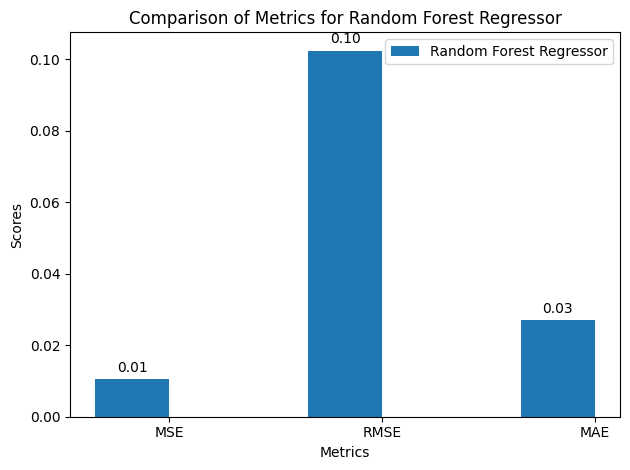

In [27]:
model = RandomForestRegressor(random_state=42)

model.fit(accelerometer_train, event_train)

predictions = model.predict(accelerometer_val)

mse_model = mean_squared_error(event_val, predictions)

rmse_model = np.sqrt(mse_model)
mae_model = mean_absolute_error(event_val, val_predictions)

metrics = ['MSE', 'RMSE', 'MAE']
model_scores = [mse_model, rmse_model, mae_model]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
rects = ax.bar(x - width/2, model_scores, width, label='Random Forest Regressor')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for Random Forest Regressor')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

autolabel(rects)

plt.tight_layout()
plt.show()

# Próximos passos:

*   Aprimorar a forma de separação dos dados
*   Construir algoritmos com configuração customizada para o problema
*   Avaliar o desempenho com métricas diversas

